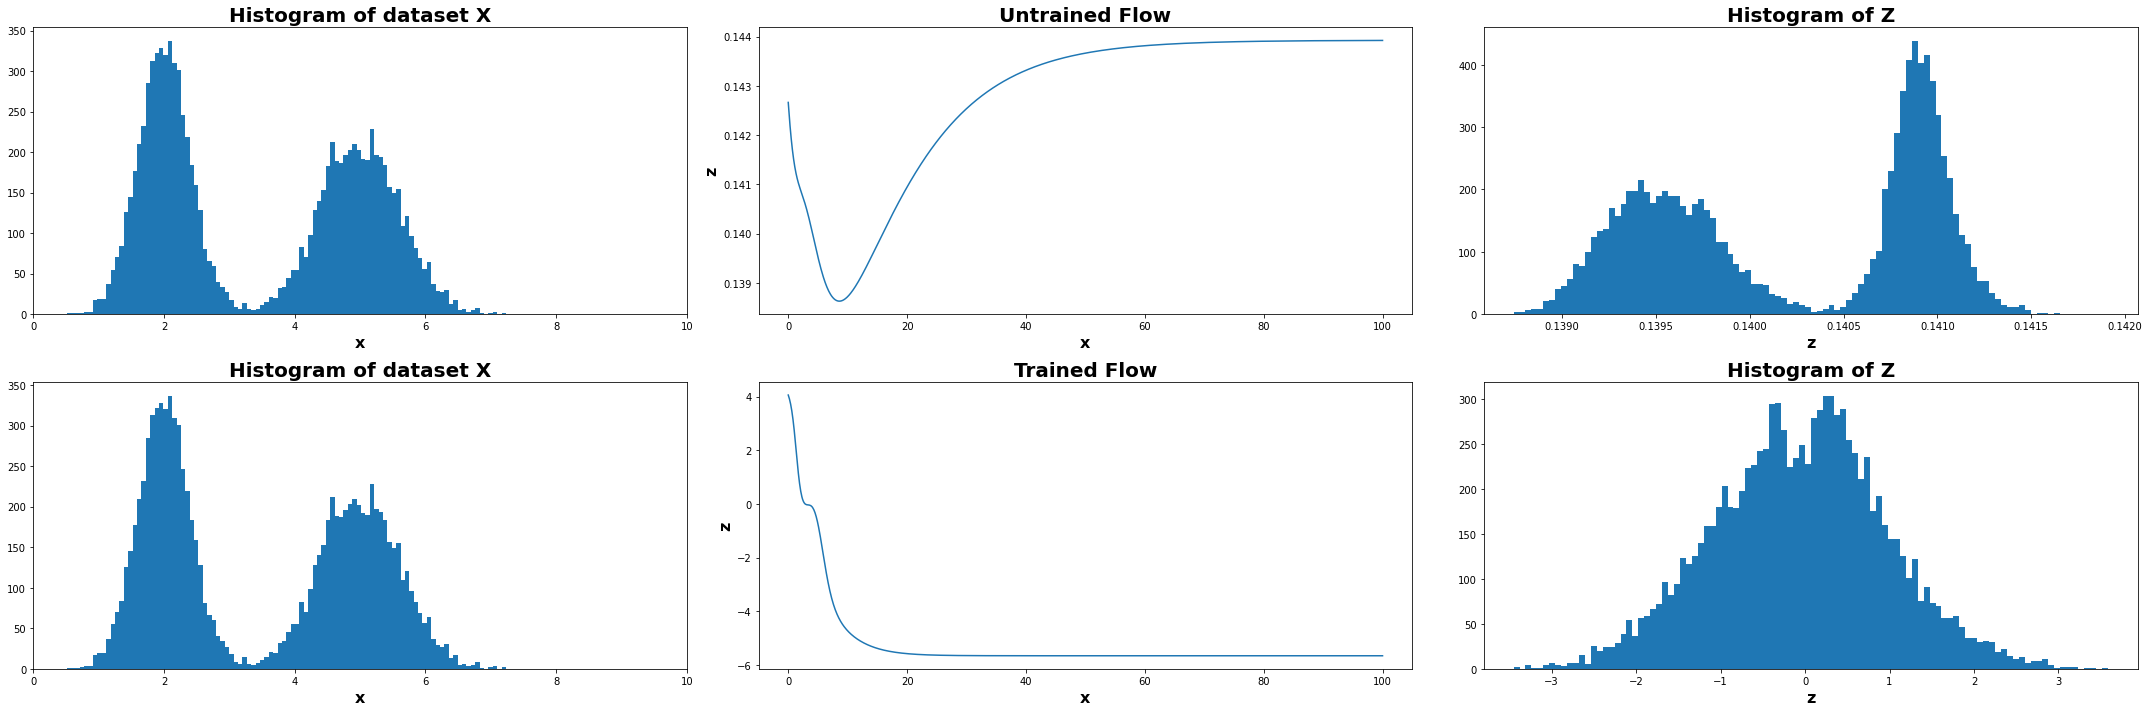

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt

MIN_X = 0.
MAX_X = 10.

TITLE_FONTSIZE = 20
AX_FONTSIZE = 16

X1 = np.random.normal(loc=2., scale=0.4, size=(5000,))
X2 = np.random.normal(loc=5., scale=0.6, size=(5000,))
X =np.clip(np.float32(np.concatenate([X1, X2], axis=0)), a_min=MIN_X, a_max=MAX_X)

class Flow1D(nn.Module):
    def __init__(self, n_layers=1, hidden_dim=10, nonlinearity=nn.Sigmoid):
        super().__init__()
        # Instantiate layers
        layers = [nn.Linear(1, hidden_dim, bias=True), nonlinearity()]
        for _ in range(n_layers):
            layers += [nn.Linear(hidden_dim, hidden_dim, bias=True), nonlinearity()]
        layers.append(nn.Linear(hidden_dim, 1, bias=True))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# instantiate flow, optim and prior
flow = Flow1D()
optim = Adam(flow.parameters(), lr=0.001)
prior = torch.distributions.Normal(0., 1.)
dataloader = torch.utils.data.DataLoader(X, batch_size=250, shuffle=True)

# plot flow before training
x_space = torch.tensor(np.linspace(0, 100, num=1000), dtype=torch.float).unsqueeze(1)
with torch.no_grad():
    z_mapping = flow(x_space)

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

for i in [0, 1]:
    ax = axes[i, 0]
    ax.hist(X, bins=100)
    ax.set_xlim(MIN_X, MAX_X)
    ax.set_xlabel("x", fontweight='bold', fontsize=AX_FONTSIZE)
    ax.set_title(f"Histogram of dataset X", fontweight='bold', fontsize=TITLE_FONTSIZE)

ax = axes[0, 1]
ax.plot(x_space.numpy(), z_mapping.detach().numpy())
ax.set_title("Untrained Flow", fontweight='bold', fontsize=TITLE_FONTSIZE)
ax.set_xlabel("x", fontweight='bold', fontsize=AX_FONTSIZE)
ax.set_ylabel("z", fontweight='bold', fontsize=AX_FONTSIZE)

ax = axes[0, 2]
ax.hist(flow(torch.tensor(X).unsqueeze(1)).detach().numpy(), bins=100)
ax.set_xlabel("z", fontweight='bold', fontsize=AX_FONTSIZE)
ax.set_title(f"Histogram of Z", fontweight='bold', fontsize=TITLE_FONTSIZE)

# training loop
losses = []
for epoch in range(200):
    for x_batch in dataloader:

        x_batch = x_batch.clone().detach().requires_grad_(True).unsqueeze(1)
        z_batch = flow(x_batch)

        p_z = prior.log_prob(z_batch)
        dz_dx = torch.autograd.grad(outputs=torch.sum(z_batch), inputs=x_batch, create_graph=True)[0]
        loss = - torch.mean(p_z + torch.log(torch.abs(dz_dx)))

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=0.1)
        optim.step()

        losses.append(float(loss.detach().numpy()))

# plot flow after training
x_space = torch.tensor(np.linspace(0, 100, num=1000), dtype=torch.float).unsqueeze(1)
with torch.no_grad():
    z_mapping = flow(x_space)

ax = axes[1, 1]
ax.plot(x_space.numpy(), z_mapping.detach().numpy())
ax.set_title("Trained Flow", fontweight='bold', fontsize=TITLE_FONTSIZE)
ax.set_xlabel("x", fontweight='bold', fontsize=AX_FONTSIZE)
ax.set_ylabel("z", fontweight='bold', fontsize=AX_FONTSIZE)

ax = axes[1, 2]
ax.hist(flow(torch.tensor(X).unsqueeze(1)).detach().numpy(), bins=100)
ax.set_xlabel("z", fontweight='bold', fontsize=AX_FONTSIZE)
ax.set_title(f"Histogram of Z", fontweight='bold', fontsize=TITLE_FONTSIZE)

plt.tight_layout()

fig.savefig("flow_exercise.png")
